## import pandas as pd
import numpy as np

# other
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
from joblib import dump, load

# plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-muted', 'dark_background'])
%matplotlib inline


# processing & model selection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

# models
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

np.random.seed(410)

# Price Prediction

**Table of Contents**:
1. Feature Engineering
2. Transformation
3. Modeling
    - Random Forest
    - Elastic Net
    - Neural Net

In [2]:
df = pd.read_csv('../data/prices_database.csv', index_col='Unnamed: 0', parse_dates=['added_date', 'date'])
df.head(2)

,player_name,quality,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,num_games,avg_goals,avg_assists,date,price
0,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,"140,067",0.58,0.38,2018-09-20,0
1,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,"140,067",0.58,0.38,2018-09-21,0


# 1. Feature Engineering

We need to construct and/or engineer the following features:
- days: number of days specific card has been available
- weekday: day of the week
- gen_pos: general player position - one of: ['defender', 'midfielder', 'forward']
- club/league/nationality grouping: group clubs and leagues according to popularity to avoid sparsity. 
- promo: binary variable indicating whether there was an active promotion.
- source: how one can obtain the card: ['base', 'packs', 'loan', 'objective', 'sbc'] - intentional overlap between base and packs
- available: binary variable indicating whether the card was obtainable on that day.
- days_release: number of days since game release
- price_dayX: card price X days before "current"

**Days**:

In [3]:
df['days'] = (df['date'] - df['added_date']).dt.days

Quick to note that some players have prices for the day before they were officially released, implying there's a mistake. Further investigation reveals that these should be offset to the next day instead. 

In [4]:
offset_resources = df[df.days == -1].resource_id.unique()       # get resource id of users who match this 

df['date'] = np.where(df.resource_id.isin(offset_resources),    # remap the date variable
                      df.date +pd.DateOffset(days=1), df.date)
df['days'] = (df.date - df.added_date).dt.days                  # reassign the days variable

df = df[df.days >= 0]                                           # remove observations that have days < 0

**Weekday**:

In [5]:
df['weekday'] = df.date.dt.weekday                              # get the day of the week

**General Position**:

In [6]:
for_pos = ['ST', 'CF', 'CAM', 'LW', 'LF', 'LM', 'RW', 'RF', 'RM']
mid_pos = ['CM', 'CDM']
def_pos = ['LB', 'LWB', 'CB', 'RB', 'RWB']

df['gen_pos'] = np.where(df.position.isin(for_pos), 'forward', np.nan)
df['gen_pos'] = np.where(df.position.isin(mid_pos), 'midfielder', df.gen_pos)
df['gen_pos'] = np.where(df.position.isin(def_pos), 'defender', df.gen_pos)

**Club/League/Nation**:

Group all leagues outside of top5 - repeat the same with teams.

Nations: Mark the 10 most common nations as 1, others 0

In [7]:
df = df[df.club != 'Icons']  # drop icons

# top 5 leagues
t_leagues = ['Premier League', 'Serie A TIM', 'LaLiga Santander', 'Ligue 1 Conforama', 'Bundesliga']
df['league'] = np.where(df.league.isin(t_leagues), df.league, 'Other')

# top clubs
t_clubs = ['Manchester United', 'Manchester City', 'Chelsea', 'Liverpool', 'Arsenal', 'Tottenham Hotspur',
           'Paris Saint-Germain', 'Juventus', 'Napoli', 'Inter', 'FC Barcelona', 'Real Madrid', 'Atlético Madrid',
           'Borussia Dortmund', 'FC Bayern München']
df['club'] = np.where(df.club.isin(t_clubs), df.club, 'other')

In [8]:
# nations
t_nations = df.groupby(['nationality']).resource_id.nunique().reset_index().sort_values(by=['resource_id'], ascending=False)[:10].nationality.values
df['nationality'] = np.where(df.nationality.isin(t_nations), df.nationality, 0)

In [21]:
t_nations

array(['Spain', 'France', 'Brazil', 'Germany', 'Argentina', 'England',
       'Italy', 'Portugal', 'Holland', 'Belgium'], dtype=object)

**Promo**:

In [9]:
promos = [[datetime(2019, 5, 10), datetime(2019, 6, 21)],       # TOTS
          [datetime(2019, 4, 5), datetime(2019, 4, 15)],        # icon release
          [datetime(2019, 3, 22), datetime(2019, 3, 30)],       # fut bday
          [datetime(2019, 3, 8), datetime(2019, 3, 16)],        # carniball
          [datetime(2019, 2, 15), datetime(2019, 2, 24)],       # rating refresh
          [datetime(2019, 2, 1), datetime(2019, 2, 8)],         # headliners
          [datetime(2019, 1, 18), datetime(2019, 1, 25)],       # ffs
          [datetime(2019, 1, 7), datetime(2019, 1, 14)],        # TOTY
          [datetime(2018, 12, 14), datetime(2018, 12, 24)],     # futmas
          [datetime(2018, 12, 7), datetime(2018, 12, 14)],      # totgs
          [datetime(2018, 11, 23), datetime(2018, 11, 26)],     # black friday
          [datetime(2018, 11, 9), datetime(2018, 11, 16)],      # rttf
          [datetime(2018, 10, 19), datetime(2018, 10, 26)]]     # halloween

def promo_assignment(ds):
    date = pd.to_datetime(ds)
    promo = 0
    for p in promos:
        if (p[0] <= date) & (p[1] >= date):
            promo = 1
            break
    return promo

df['promo'] = df['date'].apply(promo_assignment)                # apply the promo assignment

**Card Source**:

In [10]:
df.revision.fillna('MLS POTM', inplace=True)

df['source'] = 'packs'

# base cards
base = ['Normal', 'Winter Refresh']
df['source'] = np.where(df.revision.isin(base), 'packs', df.source)

# sbc cards
sbc = ['SBC', 'POTM']
df['source'] = np.where(df.revision.apply(lambda x: any(i.lower() in x.lower() for i in sbc)), 'sbc', df.source)

# loan cards
df['source'] = np.where(df.revision.str.contains('Loan'), 'loan', df.source) 
df = df[df.source != 'loan'] # remove loans

# objective cards
df['source'] = np.where(df.revision.str.contains('Ob'), 'objective', df.source)


# overwrite source for cards that were both objectives and in packs (TOTS Rodri)
resources = df[df.price>0].resource_id.unique()
df['source'] = np.where(df.resource_id.isin(resources), 'packs', df.source)

**Availability**:
- Pack cards: will be labeled as available for a week after being added to the database. This isn't always accurate but an overall approximation.
- SBC: Availability will also be set for a week - again, an approximation. 
- Objectives: Weekly availability
- Winter Upgrades + Base Cards: Available throughout except periods where they have special cards in packs. Winter upgrades replace base cards. 

In [11]:
df['available'] = np.nan

# special cards in packs, sbcs and objectives
is_special = ((df.source == 'packs') | (df.source == 'sbc') | (df.source == 'objective'))
is_available = (df.date <= (df.added_date + pd.DateOffset(7)))

df['available'] = np.where(is_special & is_available, 1, df.available)

# create a cross product to find the availability of base cards from special pack cards
base = df[df.source == 'base'][['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'available', 'resource_id']]
pack = df[df.source == 'packs'][['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'available']]
overlap = base.merge(pack, on=['player_name', 'age', 'height', 'weight', 'intl_rep', 'date'], how='inner', suffixes=('', '_special'))

overlap['available'] = np.where(overlap.available_special == 1, 0, 1)

# group by to handle multiple special card instances
overlap = overlap.groupby(['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'resource_id']).available.min().reset_index()

df_ = df.merge(overlap, on=['date', 'resource_id' ,'added_date', 'player_name'], how='left', suffixes=('', '_overlap'))

df['available'] = np.where(df.source == 'base', df_.available_overlap, df.available)          # update the availability of base cards that had special cards at some point
df['available'] = np.where((df.source == 'base') & (df.available.isnull()), 1, df.available)  # update the availability of the rest of the base cards
df.available.fillna(0, inplace=True)                                                          # update the availability of the rest of the cards

**Days Since Release**:

In [12]:
df['days_release'] = (df.date - df.date.min()).dt.days

**Price Lags**:

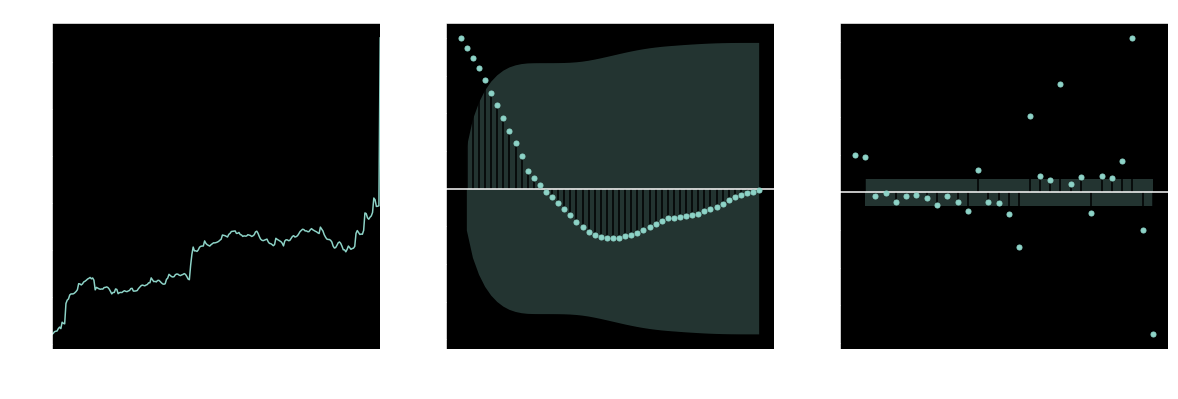

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
df.groupby('date').price.mean().plot(ax=ax[0])
_ = plot_acf(df.groupby('date').price.mean()[:50], ax=ax[1])
_ = plot_pacf(df.groupby('date').price.mean()[:30], ax=ax[2])

In [14]:
df_ = df[['date', 'resource_id', 'added_date', 'days', 'price']]

date_shifts = [1, 2, 3, 7]

for ds in date_shifts:
    df_['price_day{}'.format(ds)] = df.price.shift(ds)
    
df['price_day0'] = df['price']
for ds in date_shifts:
    if ds == 1:
        df['price_day1'] = np.where(df_.days == 1, 0, df_.price_day1)
    else:
        df['price_day{}'.format(ds)] = np.where(df_.days <= ds, 0, df_['price_day{}'.format(ds)])
    
ds_vars = ['price_day0', 'price_day1', 'price_day2', 'price_day3', 'price_day7']

# remove observations with 0 price
for ds in ds_vars:
    df = df[df[ds]>0]
    
    
# percentage difference
for ds in ds_vars[1:]:
    df[ds] = df[ds] * 100 / df['price_day0']

**PGP Statistics**:

In [15]:
df['avg_goals'] = pd.to_numeric(df.avg_goals.replace('-', 0))
df['avg_assists'] = pd.to_numeric(df.avg_assists.replace('-', 0))

**Target**:

Our target is the price of that player one week in advance, so we shift the variable. 

In [16]:
df['y_price'] = df.price.shift(-7)

df = df[df.date <= df.date.max() - timedelta(7)]

**Narrow selection and projection**:

We don't need all the remaining columns, so we narrow down our projection before proceeding.

In [17]:
drop_cols = ['quality', 'revision', 'age', 'pace', 'pace_acceleration', 'pace_sprint_speed', 'drib_agility', 'drib_balance',
             'drib_reactions', 'drib_ball_control', 'drib_dribbling', 'shoot_positioning', 'shoot_finishing', 'shoot_shot_power',
             'shoot_long_shots', 'shoot_volleys', 'shoot_penalties', 'pass_vision', 'pass_crossing', 'pass_free_kick', 'pass_short',
             'pass_long', 'pass_curve', 'def_interceptions', 'def_heading', 'def_marking', 'def_stand_tackle', 'def_slid_tackle', 
             'phys_jumping', 'phys_strength', 'phys_aggression', 'pref_foot', 'num_games', 'price', 'added_date', 'position']
df.drop(drop_cols, axis=1, inplace=True)

For the purpose of our project, we remove players with 0 target and only keep those with a rating of 81 or greater. 

In [18]:
df = df[(df.y_price!=0) & (df.overall>80)].reset_index(drop=True)

# 2. Transformation

In [ ]:
num_vars = ['overall', 'height', 'weight', 'intl_rep', 'dribbling', 'drib_composure', 'shooting', 'passing', 
            'defending', 'physicality', 'phys_stamina', 'weak_foot', 'skill_moves', 'days', 'weekday', 'days_release', 
            'price_day0', 'price_day1', 'price_day2', 'price_day3', 'price_day7']
target = 'y_price'
cat_vars = [c for c in df.columns if (c not in num_vars) & (c != 'y_price')]

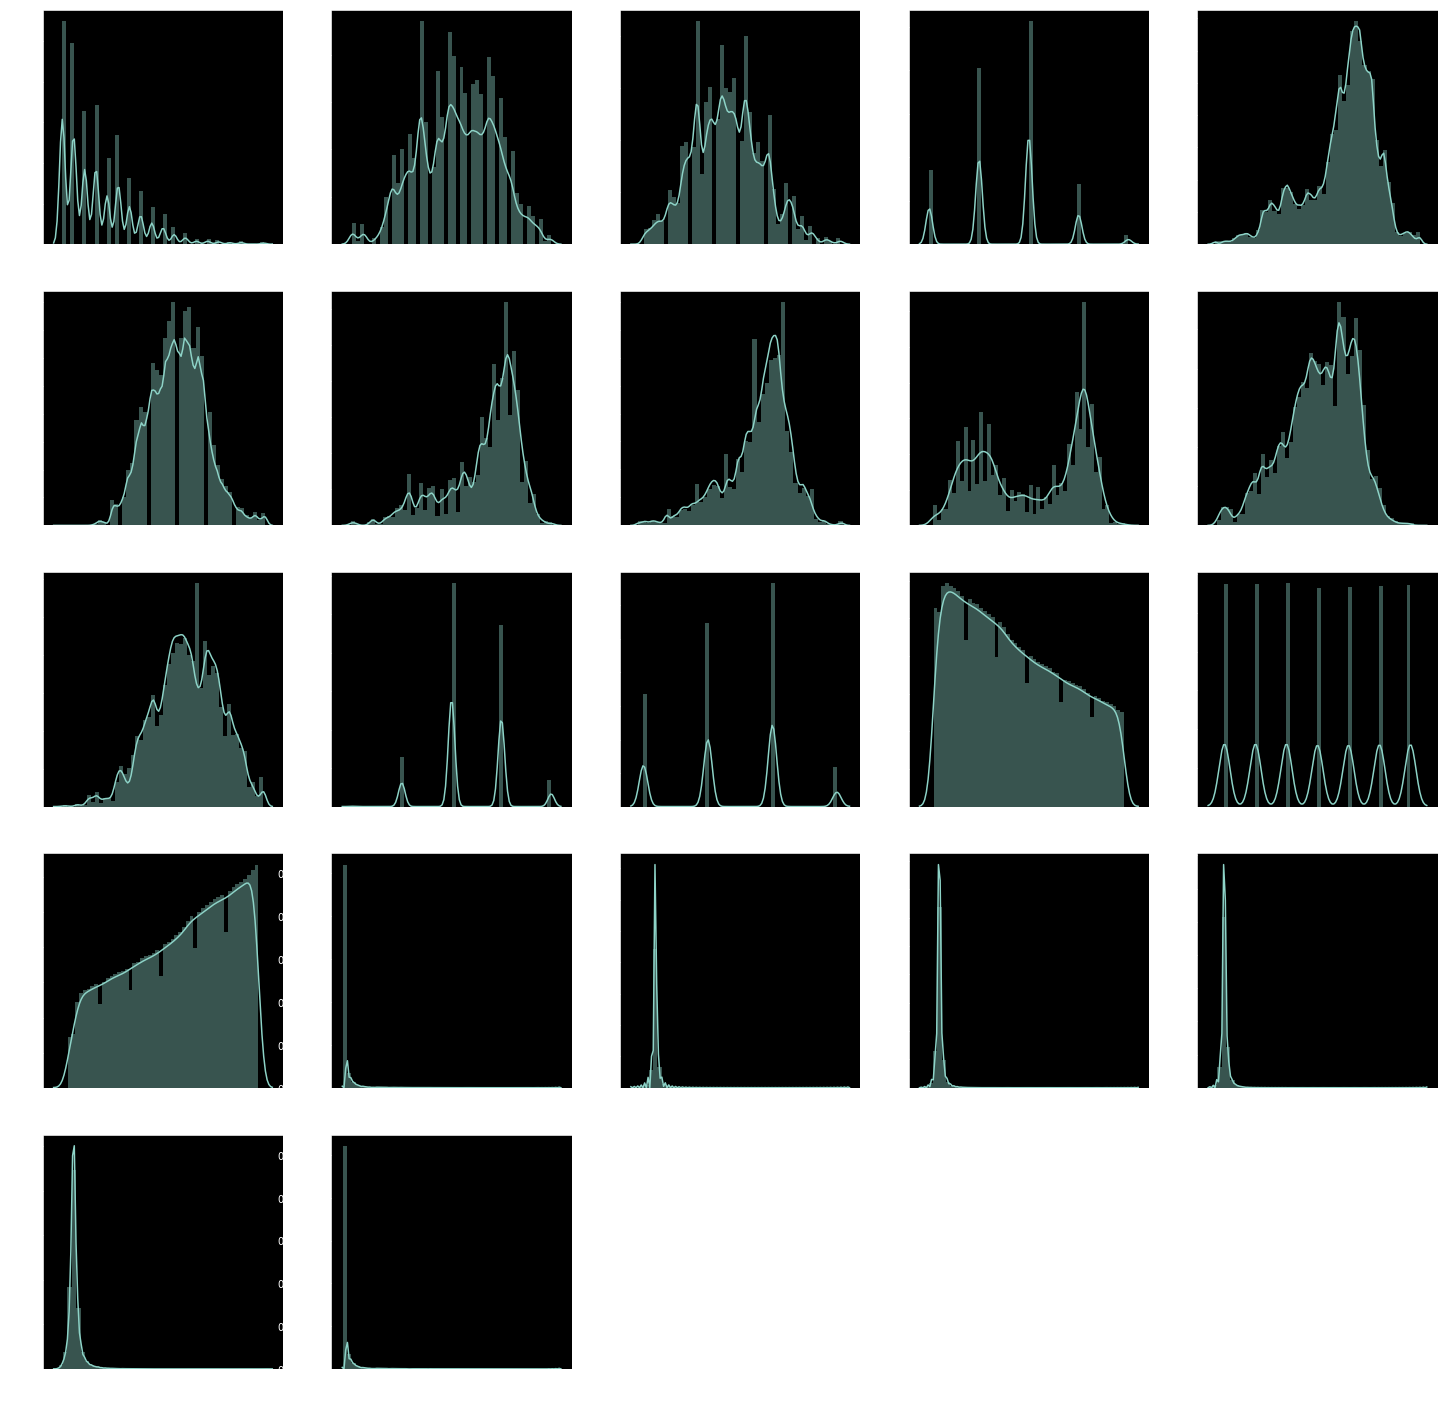

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(25,25))

all_nvars = num_vars + [target]

for i, ax_ in enumerate(axs):
    for j, ax in enumerate(ax_):
        if j+(5*i) < len(all_nvars):
            var = all_nvars[j+(5*i)]
            sns.distplot(df[var].values, ax=ax)
            ax.set_xlabel(var)
        else:
            ax.axis('off')

In [1]:
def vlogit(v):
    """
    Logit Transformation of our "DAY" variables
    """
    p = v/365
    return np.log(p) - np.log(1-p)

In [ ]:
# all price variables need to be log transformed
log_vars = [v for v in num_vars if 'price' in v]
for v in log_vars:
    df[v] = np.log(df[v].values)

# variables that need to be logit transformed
logit_vars = ['days', 'days_release']
for v in logit_vars:
    df[v] = vlogit(df[v].values)

**Export**:

In [ ]:
df.to_pickle('../data/ts_dataset.pkl')

# 3. Modeling

### Train/Test Split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_pickle('drive/My Drive/Python/Fut/ts_dataset.pkl')

In [4]:
df = pd.read_pickle('../data/ts_dataset.pkl')

In [5]:
test_size = 0.25
n_players = df.resource_id.nunique()
players = df.resource_id.unique()
players_test = np.random.choice(players, int(n_players*test_size))
players_train = np.array([x for x in players if x not in players_test])

print("""{} players in Training Set\n{} players in Test Set""".format(int(len(players_train)), int(len(players_test))))
print('{:2.2%} Split'.format(df[df.resource_id.isin(players_test)].shape[0] / df.shape[0]))

1253 players in Training Set
398 players in Test Set
20.21% Split


In [6]:
df_train = df[df.resource_id.isin(players_train)]
df_test = df[df.resource_id.isin(players_test)]

y_train = np.log(df_train.y_price)
X_train = df_train.drop(['player_name', 'resource_id', 'date', 'y_price'], axis=1)

y_test = np.log(df_test.y_price)
X_test = df_test.drop(['player_name', 'resource_id', 'date', 'y_price'], axis=1)

### Pipeline

In [7]:
cat_vars = np.array(['club', 'league', 'nationality', 'att_workrate', 'def_workrate', 'gen_pos', 'promo', 'source', 'available'])
num_vars = [x for x in X_train.columns if x not in cat_vars]

# encoding the categorical vars - purposefully handled here instead of OneHotEncoder
X_train = pd.concat([X_train[num_vars], pd.get_dummies(X_train[cat_vars])], axis=1)
X_test = pd.concat([X_test[num_vars], pd.get_dummies(X_test[cat_vars])], axis=1)

num_mask = X_train.columns.isin(num_vars)

ct = make_column_transformer((StandardScaler(), num_mask), ('passthrough', ~num_mask))

### Model 1: Random Forest

In [7]:
model = make_pipeline(ct, RandomForestRegressor(n_estimators=100, random_state=42))

param_grid = {'randomforestregressor__max_features': np.linspace(5, 10, 6).astype(int),
              'randomforestregressor__max_depth': np.linspace(3, 6, 4).astype(int)}
gs = GridSearchCV(model, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 12.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         array([ True,  True,  True,  True,  True,  True,  True,  Tru

In [8]:
rf = gs.best_estimator_
rf_score = gs.best_score_
df_test['rf_pred'] = np.exp(rf.predict(X_test))
dump(rf, r'drive/My Drive/Python/Fut/models/rf.joblib')
# dump(rf, '../models/rf.joblib')

['drive/My Drive/Python/Fut/models/rf.joblib']

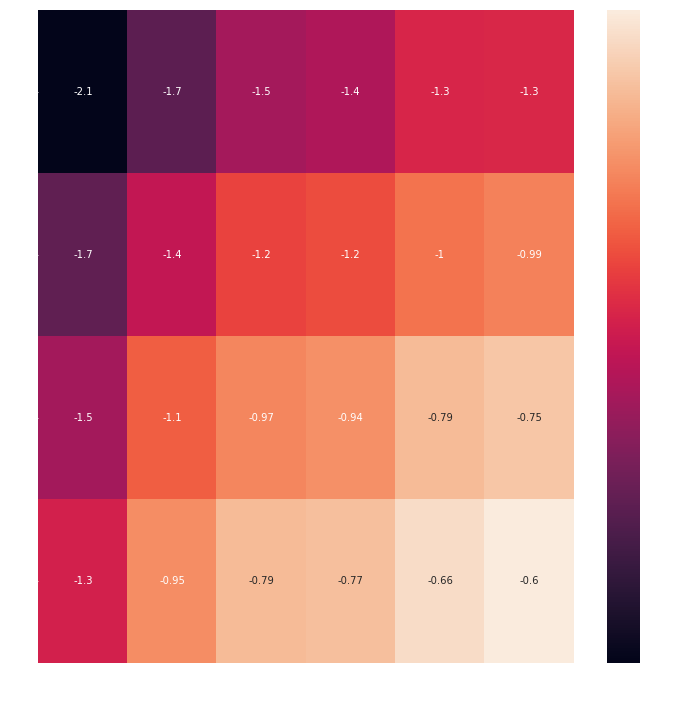

In [9]:
cv_res = pd.DataFrame(gs.cv_results_)
cv_res_pt = pd.pivot_table(cv_res, 
                           values='mean_test_score', 
                           index='param_randomforestregressor__max_depth', 
                           columns='param_randomforestregressor__max_features')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(cv_res_pt, annot=True)
ax.set_xlabel('Max Features')
ax.set_ylabel('Max Depth');

### Model 2: Elastic Net

In [10]:
model = make_pipeline(ct, ElasticNet(random_state=12))

param_grid = {'elasticnet__alpha': np.logspace(-4, -1, 5),
              'elasticnet__l1_ratio': [0.01, .1, .9, 1]}

gs = GridSearchCV(model, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         array([ True,  True,  True,  True,  True,  True,  True,  Tru

In [11]:
en = gs.best_estimator_
en_score = gs.best_score_
df_test['en_pred'] = np.exp(en.predict(X_test))
dump(en, r'drive/My Drive/Python/Fut/models/en.joblib')
# dump(en, '../models/en.joblib')

['drive/My Drive/Python/Fut/models/en.joblib']

Text(87.0, 0.5, 'Alpha')

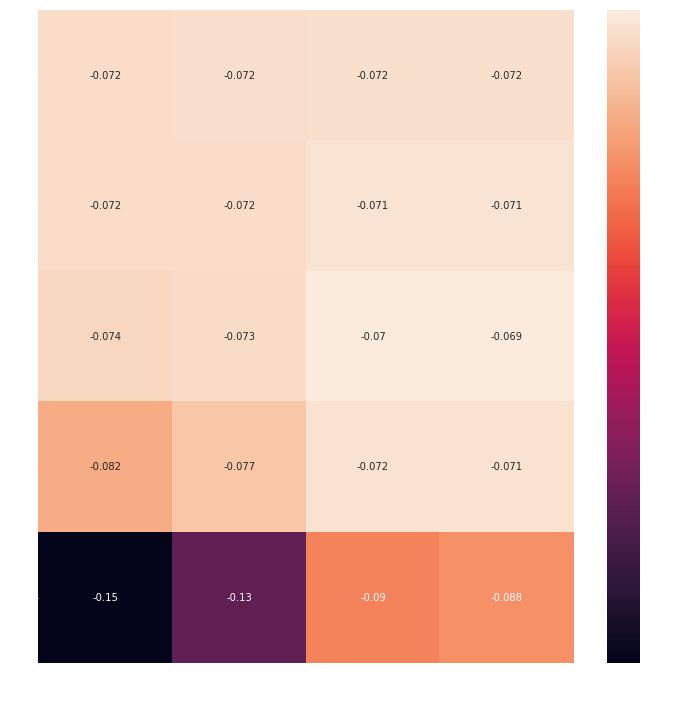

In [12]:
cv_res = pd.DataFrame(gs.cv_results_)
cv_res_pt = pd.pivot_table(cv_res, 
                           values='mean_test_score', 
                           index='param_elasticnet__alpha', 
                           columns='param_elasticnet__l1_ratio')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(cv_res_pt, annot=True)
ax.set_xlabel('L1 Ratio')
ax.set_ylabel('Alpha')

### Model 3: Neural Net

In [2]:
def make_model(hidden_size, reg_strength, optimizer='adam'):
    """
    Create the model to pass to the Keras Regressor
    """
    
    model = Sequential([
        Dense(hidden_size, input_shape=(68,), activation='relu', kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(reg_strength)),
        Dense(1, kernel_initializer='normal')
    ])
    
    # compile the above model
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [13]:
neura = KerasRegressor(make_model, epochs=6)
model = make_pipeline(ct, neura)

param_grid = {'kerasregressor__hidden_size': [32, 64, 128],
              'kerasregressor__reg_strength': np.logspace(-3, -1, 5)}

gs = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 93.4min finished








Epoch 1/6
204671/204671 [==============================] - 22s 106us/step - loss: 0.6790
Epoch 2/6
204671/204671 [==============================] - 20s 98us/step - loss: 0.1066
Epoch 3/6
204671/204671 [==============================] - 21s 101us/step - loss: 0.0899
Epoch 4/6
204671/204671 [==============================] - 20s 96us/step - loss: 0.0836
Epoch 5/6
204671/204671 [==============================] - 20s 99us/step - loss: 0.0801
Epoch 6/6
204671/204671 [==============================] - 20s 97us/step - loss: 0.0776


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         array([ True,  True,  True,  True,  True,  True,  True,  Tru

In [14]:
nn = gs.best_estimator_
nn_score = gs.best_score_
df_test['nn_pred'] = np.exp(nn.predict(X_test))
dump(nn, r'drive/My Drive/Python/Fut/models/nn.joblib')
# dump(en, '../models/en.joblib')

['drive/My Drive/Python/Fut/models/nn.joblib']

Text(87.0, 0.5, 'Hidden Size')

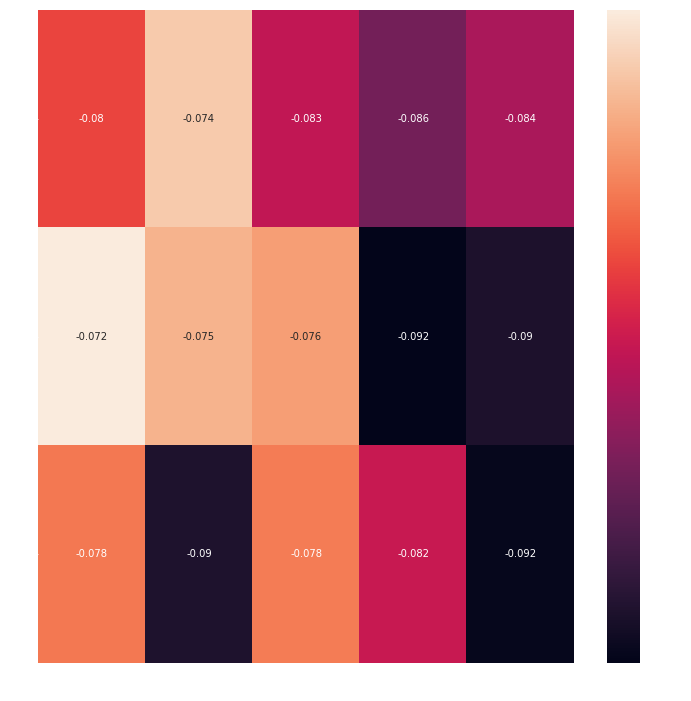

In [15]:
cv_res = pd.DataFrame(gs.cv_results_)
cv_res_pt = pd.pivot_table(cv_res, 
                           values='mean_test_score', 
                           index='param_kerasregressor__hidden_size', 
                           columns='param_kerasregressor__reg_strength')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(cv_res_pt, annot=True)
ax.set_xlabel('Reg Strength')
ax.set_ylabel('Hidden Size')

In [8]:
nn = load('../models/nn.joblib')
df_test['nn_pred'] = np.exp(nn.predict(X_test))

rf = load('../models/rf.joblib')
df_test['rf_pred'] = np.exp(rf.predict(X_test))

en = load('../models/en.joblib')
df_test['en_pred'] = np.exp(en.predict(X_test))

In [9]:
def pred_plot(resource_id):
    fig, ax = plt.subplots(1,1,figsize=(24,8))
    df_ = df_test[df_test.resource_id==resource_id]
    ax.plot(df_.date, df_.y_price.values, label='Target')
    ax.plot(df_.date, df_.en_pred.values, label='Elastic Net')
    ax.plot(df_.date, df_.nn_pred.values, label='Neural Net')
    ax.plot(df_.date, df_.rf_pred.values, label='Random Forest')
    ax.set_title(df_.player_name.values[0])
    ax.legend()

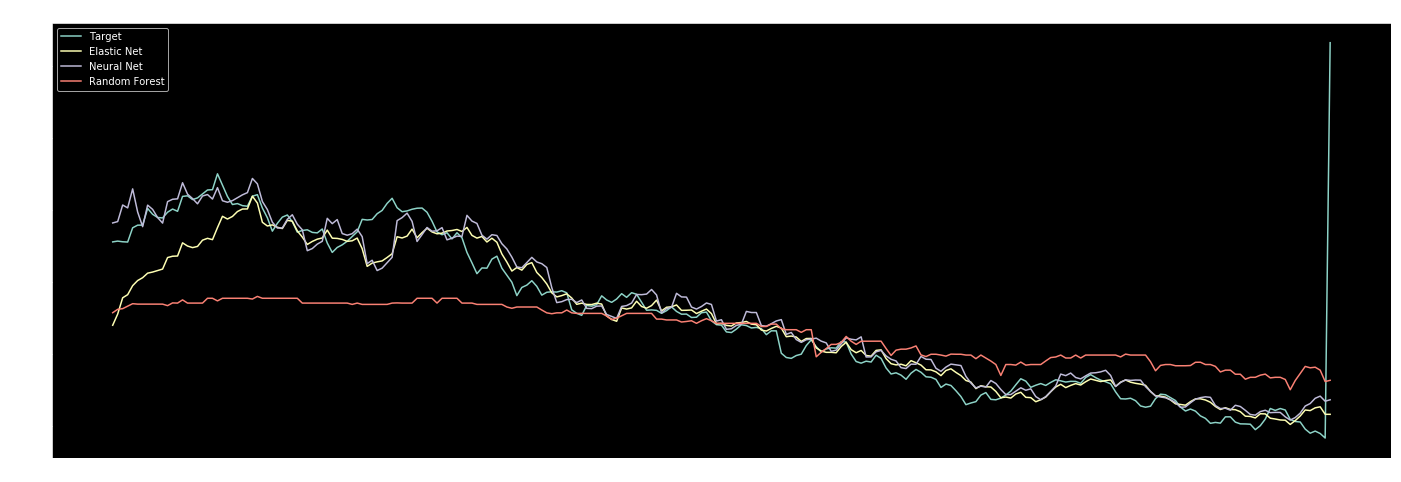

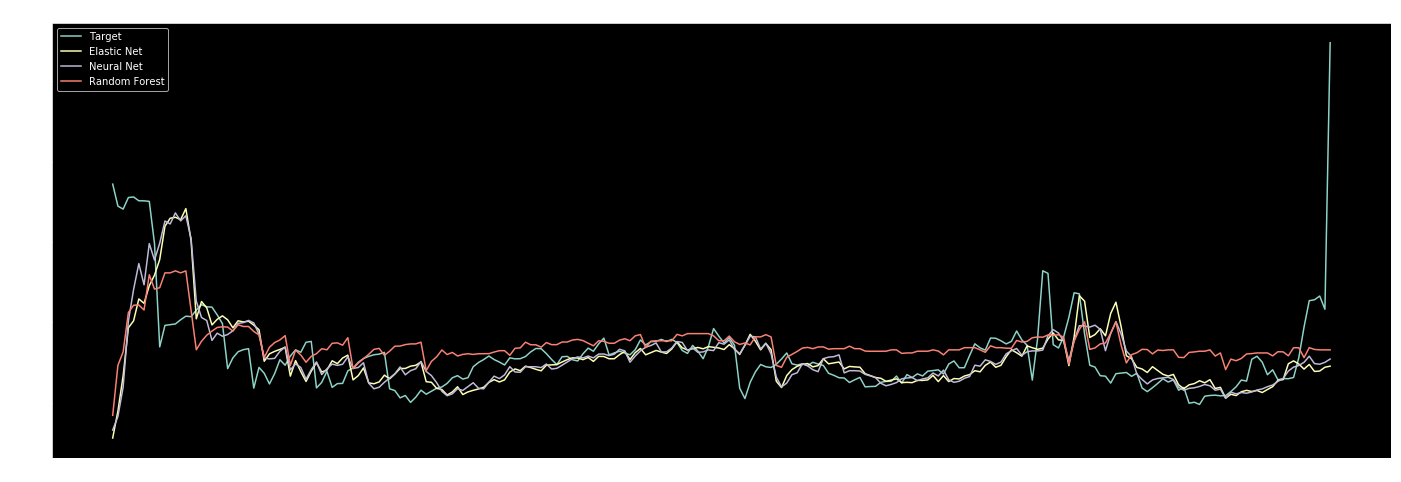

In [15]:
pred_plot(df_test[df_test.player_name=='De Bruyne'].resource_id.values[0])
pred_plot(df_test[df_test.player_name=='Kompany'].resource_id.values[0])